In [1]:
%matplotlib inline

eta=0.5
rho=-0.3
alpha=0.25

import numpy as np
Ts=np.arange(1,13)*4*7/365.0
Ks=np.arange(0.7, 1.45, 0.05)

divTimes = np.arange(0.25, 20, 0.5)
divAmount = 0.025
lambdaDiv = 0.5
Fs = np.array([1.0]*3 + [1.0-divAmount]*6 + [1.0-2*divAmount]*3)
a = np.zeros([len(Ts), 1])
for i in range(len(Ts)):
    a[i] = divAmount*np.sum(np.exp(-lambdaDiv*divTimes[Ts[i]<divTimes]))

In [2]:
import math
def iv(F, T, K):
    etaT=eta/math.sqrt(T)
    l=etaT/alpha
    logK=math.log(K/F)
    return alpha*(1+1/2*rho*l*logK+1/12*(2-3*rho**2)*(l*logK)**2)

In [3]:
ivs=np.zeros((len(Ts),len(Ks)))
for i in range(len(Ts)):
    for j in range(len(Ks)):
        ivs[i,j]=iv(Fs[i], Ts[i], Ks[j])

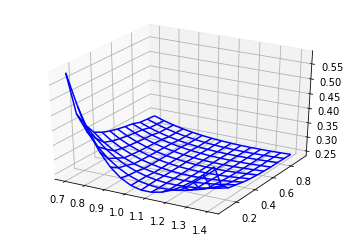

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
X, Y = np.meshgrid(Ks, Ts)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, ivs, color='blue')
plt.savefig('ivs.pdf')

In [16]:
from scipy.stats import norm

def compute_black_scholes(F_surf, T_surf, K_surf, ivs_surf):
    d1 = (np.log(F_surf/K_surf) + 0.5 * np.square(ivs_surf) * T_surf)/(ivs_surf*np.sqrt(T_surf))
    d2 = d1 - ivs_surf * np.sqrt(T_surf)
    
    C = F_surf * norm.cdf(d1) - K_surf * norm.cdf(d2)
    P = K_surf * norm.cdf(-d2) - F_surf * norm.cdf(-d1)
    vega = np.square(T_surf) * norm.pdf(d1)
    
    return C, P, vega

n=200000
nT=len(Ts)
Ks=np.arange(-2, 2.5, 0.5)
nK=len(Ks)

x_lv_ext = np.array([Ks*0.2*math.sqrt(Ts[i]) for i in range(nT)]) 
K_ext = np.exp(x_lv_ext)
T_ext = np.array([Ts for _ in range(nK)]).T
F_ext = np.array([Fs for _ in range(nK)]).T

ivs=np.zeros((len(Ts),len(Ks)))
for i in range(len(Ts)):
    for j in range(len(Ks)):
        ivs[i,j]=iv(F_ext[i, j], T_ext[i, j], K_ext[i, j])

calls_mkt, puts_mkt, vega_mkt = compute_black_scholes(F_ext, T_ext, K_ext, ivs)
lv = np.copy(ivs)
lv.fill(0.2)

In [27]:
dt=7.0/365.0
sqrtDt=math.sqrt(dt)
nTw = nT*4

import tensorflow as tf

class LocalVol:
    
    def __init__(self):
        
        with tf.device("/gpu:0"):

            self.lv_t=tf.Variable(lv, dtype=tf.float32)
            self.Ts_t=tf.constant(Ts, dtype=tf.float32)
            self.x_lv_ext_t=tf.constant(x_lv_ext, dtype=tf.float32)

            W = tf.random_normal((nTw, n), dtype=tf.float32)

            def cond(i, _1, _2):
                return i < nTw

            def body(i, R, ta):
                j = tf.floordiv(i, 4)

                dx_lv = 0.5*0.2*tf.sqrt(self.Ts_t[j])
                indices_x_d = tf.minimum(tf.maximum(0, tf.cast(R / dx_lv, dtype=tf.int32) + len(Ks)//2), len(Ks)-1)
                indices_x_u = tf.minimum(indices_x_d+1, len(Ks)-1)
                sigma_interp = (tf.gather(self.x_lv_ext_t[j,:], indices_x_u)-R) / dx_lv * tf.gather(self.lv_t[j, :], indices_x_d) + \
                               (R-tf.gather(self.x_lv_ext_t[j,:], indices_x_d)) / dx_lv * tf.gather(self.lv_t[j, :], indices_x_u)

                sigma_t = tf.where(R<=self.x_lv_ext_t[j, 0],
                                   self.lv_t[j, 0]*np.ones((1,n), dtype=np.float32),
                                   tf.where(R>=self.x_lv_ext_t[j, -1],
                                            self.lv_t[j, -1]*np.ones((1,n), dtype=np.float32),
                                            sigma_interp))
                R = R + sqrtDt*sigma_t*W[i, :] - 0.5*np.square(sigma_t)*dt

                ta = ta.write(i, R)
                return i+1, R, ta

            ta = tf.TensorArray(dtype=tf.float32, size=nTw)
            _0, _1, ta = tf.while_loop(cond, body, [0, tf.zeros([1, n]), ta])

            C = tf.squeeze(ta.stack())
            X = tf.exp(C[3::4, :])
            
            a_t = tf.constant(a, shape=[len(Ts), 1], dtype=tf.float32)
            F_t = tf.constant(Fs, shape=[len(Ts), 1], dtype=tf.float32)
            elt_t = tf.constant(np.exp(lambdaDiv*Ts), shape=[len(Ts), 1], dtype=tf.float32)
            elt_t = tf.tile(elt_t, (1, n))
            at_t = tf.tile(a_t, (1, n))
            S = a_t + (F_t - elt_t*at_t)*X
            S = S + lambdaDiv * at_t * tf.cumsum(4*dt*elt_t*X, axis=0)

            S_all = tf.expand_dims(S, 2)
            S_all = tf.tile(S_all, (1, 1, nK))

            K_all = tf.constant(K_ext, shape=(nT, nK), dtype=tf.float32)
            K_all = tf.expand_dims(K_all, 1)
            K_all = tf.tile(K_all, (1, n, 1))

            self.calls_mod = tf.reduce_mean(tf.maximum(0.0, S_all - K_all), axis=1)
            self.puts_mod = tf.reduce_mean(tf.maximum(0.0, K_all - S_all), axis=1)

            err_call = tf.reduce_sum(tf.boolean_mask(tf.square((self.calls_mod-calls_mkt)/vega_mkt), K_ext >= F_ext))
            err_put = tf.reduce_sum(tf.boolean_mask(tf.square((self.puts_mod-puts_mkt)/vega_mkt), K_ext < F_ext))
            err = err_call + err_put

            optim = tf.train.AdamOptimizer(learning_rate=0.0025)
            self.training_op = optim.minimize(err)
            self.init = tf.global_variables_initializer()
        
            
    def calibrate(self):
        with tf.Session() as sess:
            sess.run(self.init)
            for i in range(100):
                print(i)
                sess.run(self.training_op)
            return sess.run([self.puts_mod, self.calls_mod, self.lv_t])
        
lv_mod = LocalVol()
from datetime import datetime
t0 = datetime.now()
p, c, lv_calibrated = lv_mod.calibrate()
t1 = datetime.now()
print("time: {}".format(t1-t0))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
time: 0:01:11.710822


In [28]:
r=np.where(K_ext < F_ext,p-puts_mkt,c-calls_mkt)/np.where(K_ext < F_ext,puts_mkt,calls_mkt)
r

array([[-0.13150787, -0.01485366,  0.03765858,  0.03889699,  0.02052464,
         0.00866131, -0.01564155, -0.04589405, -0.10652373],
       [-0.08708024,  0.00386717,  0.03470037,  0.02853107,  0.00995738,
        -0.0062569 , -0.01825105, -0.01857066, -0.04433058],
       [-0.08780651,  0.00035741,  0.02545112,  0.01965049,  0.00124681,
        -0.01940304, -0.02491186, -0.01598227, -0.03697527],
       [-0.00538012,  0.04803295,  0.04978912,  0.02709985,  0.00458539,
        -0.00974001,  0.00394232,  0.01592219, -0.01908985],
       [-0.03155243,  0.02631613,  0.03460793,  0.0186753 ,  0.00321105,
        -0.01311409, -0.00155847,  0.01749868, -0.00288616],
       [-0.04567319,  0.01733574,  0.02777616,  0.01474707,  0.00129728,
        -0.0129185 ,  0.0031895 ,  0.03381899,  0.03287424],
       [-0.05343533,  0.01305559,  0.02444829,  0.01334798,  0.00203893,
        -0.01058646,  0.00915557,  0.03958392,  0.04412181],
       [-0.06782264,  0.00045069,  0.01493166,  0.00734554,  0

In [10]:
from tabulate import tabulate
print(tabulate(100*r, tablefmt="latex", floatfmt=".1f"))

\begin{tabular}{rrrrrrrrr}
\hline
 -5.7 &  1.2 &  3.4 &  2.4 &  0.7 & -0.7 & -1.5 & 0.3 &  1.2 \\
 -5.4 & -0.4 &  0.5 & -0.2 &  0.2 & -0.6 &  0.1 & 1.2 & -0.7 \\
 -4.5 &  0.1 &  0.0 & -0.6 & -0.3 & -0.8 &  0.4 & 2.3 &  1.4 \\
 -1.3 &  1.0 &  0.5 & -0.1 &  0.1 &  0.2 &  1.9 & 2.9 & -1.7 \\
 -1.8 &  1.0 &  0.8 &  0.2 &  0.1 & -0.2 &  1.0 & 2.1 & -1.4 \\
 -2.5 &  1.1 &  1.1 &  0.5 &  0.5 &  0.6 &  1.8 & 2.4 & -2.5 \\
 -1.9 &  1.5 &  1.2 &  0.5 &  0.9 &  1.3 &  3.0 & 4.7 &  1.8 \\
 -1.4 &  1.6 &  0.9 &  0.3 &  1.0 &  1.6 &  3.7 & 5.8 &  4.1 \\
 -2.0 &  1.2 &  0.4 & -0.1 &  0.8 &  1.4 &  3.5 & 5.5 &  4.8 \\
  3.1 &  3.6 &  2.0 &  1.0 &  2.2 &  3.6 &  5.9 & 9.7 &  8.6 \\
  0.5 &  1.9 &  0.8 &  0.3 &  1.3 &  2.3 &  3.8 & 6.4 &  5.6 \\
 -0.6 &  0.9 & -0.1 &  0.0 &  1.4 &  2.2 &  3.6 & 6.1 &  5.2 \\
\hline
\end{tabular}


In [29]:
np.median(np.abs(r))

0.018410855421199177